# Signal Processing Project: Audio Declipping with Social Sparsity

- Dorin Doncenco
- Benjamin Maudet

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#import renamed libraries from the numerical toolbox
from local_signal import *
from general import *

import scipy.io.wavfile as wav
from IPython.display import Audio
from IPython.display import display

The declipping problem can be formulated as follows:

$\hat{a} = argmin_a ||a||_0 $,

s.t. $||y^r - M^r \phi a||_2^2 \leq \epsilon $

Where:
- $a \in C^N$ : Synthesis coefficients
- $\phi \in C^{T \times N}$ : Synthesis operator, Gabor Frames (STFT) is well suited for audio signals, therefore $\phi$ represents the matrix associated with the Gabor dictionary
- $y^r = M^r y \in R^M$ : The reliable samples
- $y \in R^T $ : The observed signal
- $M^r \in R^{M \times T} $ : Matrix comprised of those rows in the identity matrix that chooses the entries of reliable samples
- $M^c \in R^{(T-M) \times T} $ : The matrix choosing the clipped samples,
- $\theta^{clip} \in R^{(T-M)} $ : The vector  of clipped samples which can only have values $\pm \theta^{clip}$

Specifically, for audio declipping, we have:

$ \hat{a} = argmin_a ||a||_0 $,

s.t. $ ||y^r - M^r \phi a||^2_2 \leq \epsilon $ and $ |M^c \phi a| \geq |\theta^{clip}|$

The paper proposes to relax the constraint on the optimization problem using the squared hinge function:

$ h^2 : R \to R_+, z \to    h^2(z) = z^2 , :if z \lt 0, else:  0$

if $ z = x - \theta^{clip}$ for $\theta^{clip} \gt 0$,

The squared hinge sets x "free" if $|x| \geq \theta^{clip}$, so we can use the notation:

$[\theta^{clip} - x]^2_+ = \sum_{k:\theta^{clip}_k\gt 0} h^2(x_k - \theta^{clip}_k) + \sum_{k:\theta^{clip}_k\lt 0} h^2(\theta^{clip}_k - x_k) $

The unconstrained convex optimization problem becomes:

$ argmin_a \frac{1}{2} ||y^r - M^r \phi a||^2_2 + \frac{1}{2} [\theta^{clip} - M^c \phi a]^2_+ + \lambda||a||_1$

Additionally:

$\phi$: tight Gabor frame as time-frequency dictionary

$\phi*$: The corresponding analysis operator aka Sliding Window or STFT;

In the paper, $\gamma$ is set to 0.9.



## Loading the signal

In [2]:
music_rate, music_signal = wav.read('music.wav')
# convert music_signal to float and normalize to [-1, 1]
music_signal = music_signal.astype(np.float32) / np.max(np.abs(music_signal))
# display music object
Audio(music_signal, rate=music_rate)

In [3]:
# clip signal to values between -0.3 and 0.3
music_signal_clipped = np.clip(music_signal, -0.3, 0.3)
#append a 1 at the end of the signal to reduce volume (the clipping makes the audio player renormalize the sound)
music_signal_clipped = np.append(music_signal_clipped, 1)
Audio(music_signal_clipped, rate=music_rate)


## Defining functions

In [4]:
from scipy.signal import istft, stft
Psi = lambda a: istft(a, fs=music_rate, nperseg=1024, noverlap=512)[1]
PsiS = lambda a: stft(a, fs=music_rate, nperseg=1024, noverlap=512)[2]

In [5]:
def hinge_clipped_grad(x, clipping_values):
    """ 
    Computes the gradient of the squared hinge loss with clipping.
    """
    grad = np.zeros_like(x)
    mask_negative_clips = clipping_values < 0
    mask_positive_clips = clipping_values > 0

    grad[mask_negative_clips] = 2 * (clipping_values[mask_negative_clips] - x[mask_negative_clips])
    grad[mask_positive_clips] = 2 * (x[mask_positive_clips] - clipping_values[mask_positive_clips])

    grad[grad > 0] = 0
    grad[mask_positive_clips] = -grad[mask_positive_clips]
    grad[mask_negative_clips] = grad[mask_negative_clips]
        
    return grad

### Thresholding operators

In [6]:
def lasso_shrinkage(x, lambda_):
    """ 
    Computes the soft-thresholding operator.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = 1 - lambda_ / np.abs(x)
    result[result < 0] = 0
    return result * x

def windowed_group_lasso(x, lambda_, window_size):
    """ 
    Computes the windowed group lasso shrinkage.
        x: input signal in the time-frequency domain
        lambda_: threshold
        window_size: size of the neighborhood in the time dimension
    """ 
    denominators = np.zeros_like(x)
    leftspan = rightspan = window_size // 2

    for i in range(x.shape[1]):
        left = max(0, i - leftspan)
        right = min(x.shape[1], i + rightspan)
        denominators[:, i] = np.sqrt(np.sum(np.abs(x[:, left:right])**2, axis=1))
    
    result = 1 - lambda_ / denominators
    result[result < 0] = 0
    return result * x


def empirical_weiner(x, lambda_):
    """ 
    Computes the empirical Wiener filter.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = 1 - lambda_**2 / np.abs(x)**2
    result[result < 0] = 0
    return result * x

def persistant_empirical_weiner(x, lambda_, window_size):
    """ 
    Computes the persistant empirical Wiener filter.
        x: input signal in the time-frequency domain
        lambda_: threshold
        window_size: size of the neighborhood in the time dimension
    """ 
    denominators = np.zeros_like(x)
    leftspan = rightspan = window_size // 2

    for i in range(x.shape[1]):
        left = max(0, i - leftspan)
        right = min(x.shape[1], i + rightspan)
        denominators[:, i] = np.sum(np.abs(x[:, left:right])**2, axis=1)
    
    result = 1 - lambda_**2 / denominators
    result[result < 0] = 0
    return result * x

def hard_thresholding(x, lambda_):
    """ 
    Computes the hard thresholding operator.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = np.zeros_like(x)
    idx = np.abs(x) > lambda_
    result[idx] = x[idx]
    return result

## ISTA

$a^{(0)} \in C^N, z^{(0)} = a^{(0)}, k = 1, \delta = ||\phi \phi^*|| $

Repeat:

$ g1 = -\phi^*M^{r^T}(y^r - M^r \phi z^{(k-1)})$

$ g2 = -\phi^* M^{c^T} [\theta^{clip} - M^c \phi z^{(k-1)}]_+ $

$ a^{(k)} = S_{\lambda / \delta} ( z^{(k-1)} - \frac{1}{\delta}(g1+g2))$

$ z^{(k)} = a^{(k)} + \gamma (a^{(k)} - a^{(k-1)})$

$ k = k + 1 $

until convergence

In [7]:
def snr(signal, computed_signal, mask=None):
    """ 
    Computes the signal to noise ratio. If a mask is provided, the SNR is computed only on the masked part of the signal.
    """
    if mask is None:
        return 20 * np.log10(np.abs(np.sum(signal)) / np.abs(np.sum(signal - computed_signal)))
    return 20 * np.log10(np.abs(np.sum(signal[mask])) / np.abs(np.sum((signal[mask] - computed_signal[mask]))))

In [8]:
def declipping_ista(clipped_audio, clip_threshold, gamma, thresholding_function, lambdas_, n_iter=1000, i_between_lambdas=500, music_signal=None, verbose=False):
    """ 
    Performs declipping using the gradient of the hinge loss, ISTA algorithm.
        clipped_audio: clipped audio signal
        clip_threshold: threshold used for clipping
        gamma: step size
        thresholding_function: function used for thresholding
        lambdas_: list of lambdas to use
        n_iter: number of iterations
        i_between_lambdas: number of iterations before changing lambda
        music_signal: original music signal (used for monitoring progress)
    """
    lambda_i = 0
    lambda_ = lambdas_[lambda_i]

    audio_length = len(clipped_audio)
    #Mr: mask of unclipped values (reliable samples)
    #Mc: mask of clipped values
    values_below = clipped_audio < clip_threshold
    values_above = clipped_audio > -clip_threshold
    Mr = values_below * values_above
    Mc = ~Mr

    theta_clip = np.sign(clipped_audio[Mc]) * np.max(np.abs(clipped_audio[Mc]))
    #yr: reliable samples
    yr = clipped_audio[Mr]

    # initialize alpha, z
    frequency_domain = PsiS(clipped_audio)
    # alpha = np.zeros_like(frequency_domain)
    # alpha_prev = alpha.copy()
    # z = alpha.copy()
    alpha = frequency_domain.copy()
    alpha_prev = alpha.copy()
    z = alpha.copy()

    #z_prev is used only to monitor convergence
    z_prev = z.copy()+1

    masked_snr_record = []
    unmasked_snr_record = []
    
    i_between_lambdas_start = 0
    # ISTA loop
    for i in range(n_iter):
        if i % 100 == 0:
            print(f"{i+1} / {n_iter}", end="\r")


        # if i % 100 == 0 and music_signal is not None:
        #     #this section is using signal that the algorithm should not have access to; it's just for monitoring progress
        #     computed_snr = snr(music_signal, Psi(z)[:audio_length], mask=Mc)
        #     print('Iteration: ', i, ' SNR: ', computed_snr)
        g1 = Psi(z)[:audio_length]
        g1 = g1[Mr]
        g1 = yr - g1
        temp_g1 = np.zeros_like(clipped_audio)
        temp_g1[Mr] = g1
        g1 = -PsiS(temp_g1)

        g2 = Psi(z)[:audio_length]
        g2 = g2[Mc]
        g2 = 0.5 * hinge_clipped_grad(g2, theta_clip)
        temp_g2 = np.zeros_like(clipped_audio)
        temp_g2[Mc] = g2
        g2 = -PsiS(temp_g2)
        alpha = thresholding_function(z - (1./1.) * (g1 + g2), lambda_)
        z = alpha + gamma*(alpha - alpha_prev)
        alpha_prev = alpha.copy()

        if music_signal is not None:
            #this section is using signal that the algorithm should not have access to; it's just for monitoring progress
            if i - i_between_lambdas_start == i_between_lambdas and verbose:
                print("Changing current lambda because of too many iterations")
            masked_snr = snr(music_signal, Psi(z)[:audio_length], mask=Mc)
            unmasked_snr = snr(music_signal, Psi(z)[:audio_length])
            if verbose:
                print('Reached iteration ', i, ' with lambda = ', lambda_, ' and SNR (masked) = ', masked_snr, ' and SNR (unmasked) = ', unmasked_snr)
            masked_snr_record.append(masked_snr)
            unmasked_snr_record.append(unmasked_snr)

        #check if we have converged
        if (np.allclose(z, z_prev) or i - i_between_lambdas_start == i_between_lambdas):

            if lambda_i == len(lambdas_) - 1:
                break

            lambda_i += 1
            lambda_ = lambdas_[lambda_i]
            i_between_lambdas_start = i
        z_prev = z.copy()
            
    unclipped_audio = Psi(z)[:audio_length]
    return unclipped_audio, masked_snr_record, unmasked_snr_record

## Running the algorithms with different thresholding operators

In [9]:
clip_threshold = 0.2
clipped_audio = np.clip(music_signal, -clip_threshold, clip_threshold)
gamma = 0.9
thresholding_functions = {
    'HT': hard_thresholding,
    'L': lasso_shrinkage,
    'EW': empirical_weiner,
    'WGL': lambda x, lambda_: windowed_group_lasso(x, lambda_, 3),
    'PEW': lambda x, lambda_: persistant_empirical_weiner(x, lambda_, 3)
}
lambdas_ = np.logspace(-1, -4, 10)

# maximum amount of iterations, after which we stop the algorithm
n_iter = 15000

# number of iterations before changing lambda
i_between_lambdas = 100

results = {}

for name, thresholding_function in thresholding_functions.items():
    print(f"Processing with S = {name}...")
    unclipped_audio, masked_snr_record, unmasked_snr_record = declipping_ista(
        clipped_audio,
        clip_threshold,
        gamma,
        thresholding_function,
        lambdas_,
        n_iter,
        i_between_lambdas,
        music_signal,
    )
    results[name] = {
        'unclipped_audio': unclipped_audio,
        'masked_snr_record': masked_snr_record,
        'unmasked_snr_record': unmasked_snr_record,
    }

Processing with S = HT...
Processing with S = L...
Processing with S = EW...
Processing with S = WGL...
Processing with S = PEW...


## Results

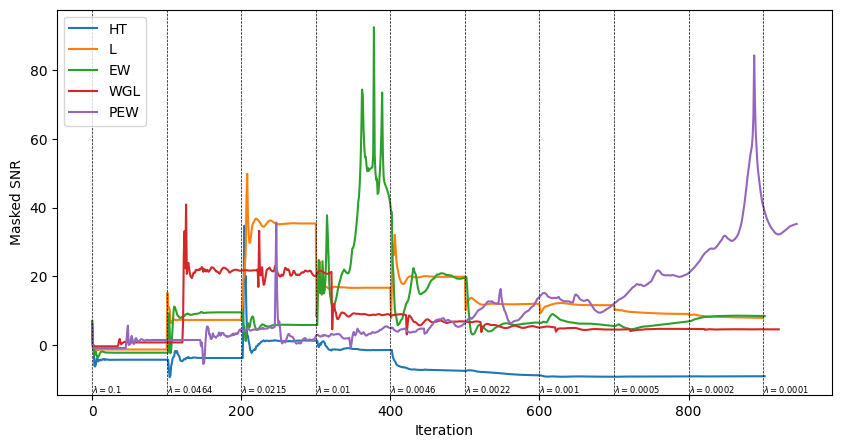

In [10]:
# plot masked SNR for each method over time
plt.figure(figsize=(10, 5))
for name, result in results.items():
    plt.plot(result['masked_snr_record'], label=name)
# put black vertical lines at each lambda change (every i_between_lambdas iterations)
for i, lambda_value in enumerate(lambdas_):
    x_value = i_between_lambdas * i
    plt.axvline(x_value, color='black', linestyle='--', linewidth=0.5)
    lambda_value = np.round(lambda_value, 4)
    plt.text(x_value, plt.gca().get_ylim()[0], f'$\lambda={lambda_value}$', verticalalignment='bottom', fontsize=6)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Masked SNR')
plt.show()

In [11]:
print("Final SNR:")
for name, result in results.items():
    print(name)
    print("  SNR on the missing parts:", result['masked_snr_record'][-1])
    print("  SNR on the whole signal:", result['unmasked_snr_record'][-1])

Final SNR:
HT
  SNR on the missing parts: -9.00927484035492
  SNR on the whole signal: -27.305212020874023
L
  SNR on the missing parts: 7.9678380489349365
  SNR on the whole signal: -10.057435035705566
EW
  SNR on the missing parts: 8.499172329902649
  SNR on the whole signal: -9.674110412597656
WGL
  SNR on the missing parts: 4.621061682701111
  SNR on the whole signal: -13.344767093658447
PEW
  SNR on the missing parts: 35.28259754180908
  SNR on the whole signal: 16.538411378860474


Let's see how our recovered signal compares to the original!

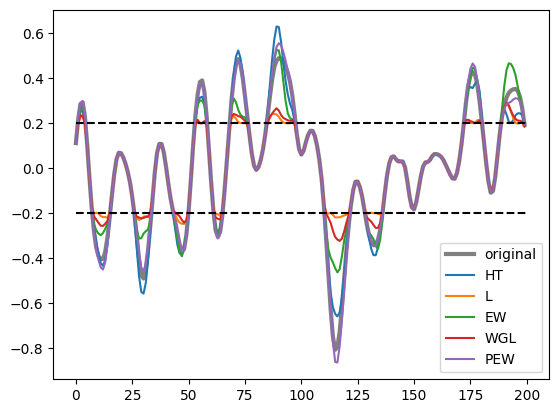

In [12]:
interval = 45000
window = 200

plt.plot(music_signal[interval:interval+window], linewidth=3, label='original', color="gray")
for name, result in results.items():
    plt.plot(result["unclipped_audio"][interval:interval+window], label=name)

# show black lines at clipping threshold
plt.plot([0, window], [-clip_threshold, -clip_threshold], 'k--')
plt.plot([0, window], [clip_threshold, clip_threshold], 'k--')
plt.legend()
plt.show()

The original audio:

In [13]:
Audio(music_signal, rate=music_rate)

The clipped audio:

In [14]:
# adding 1 at the end of the signal to reduce volume (the clipping makes the audio player renormalize the sound)
Audio(np.append(clipped_audio, 1), rate=music_rate)

The computed audios:

In [15]:
for name, result in results.items():
    print(name)
    display(Audio(result["unclipped_audio"], rate=music_rate))

HT


L


EW


WGL


PEW
